In this notebook, we will create a network for some parties and analyze the patterns obtained. We may focus on 3 parties: PSL (party of the president), PT (party of the previous presidents and the main opposition), NOVO (right-wing and liberal, as they say) and PDT ( floating about center and left-center-wing).

In [0]:
!pip install nxviz
!pip install unidecode

In [0]:
# Import necessary modules
import pandas as pd
import matplotlib.pyplot as plt

# Building the graph
import requests
from sklearn.feature_extraction.text import CountVectorizer
from itertools import combinations 
import networkx as nx
from nxviz import CircosPlot

from unidecode import unidecode

In [0]:
dataset = pd.read_csv('speeches.csv')

In [0]:
dataset.loc[:, 'speech'] = dataset.speech.str.replace('\r', '')
dataset.loc[:, 'speech'] = dataset.speech.str.replace('\n', '')
dataset.loc[:, 'speech'] = dataset.speech.str.replace('-', '')

## Graphs

The graphs will be created by following the steps of the methos explained on this [paper](https://scholar.google.com.br/scholar?q=Identifying+the+Pathways+for+Meaning+Circulation+using+Text+Network+Analysis&hl=pt-BR&as_sdt=0&as_vis=1&oi=scholart).

We will use the 2-gram and 5-gram to generate the graph. That is, given a phrase, we extract the words in groups of 2 and 5 words. For exemple:

```
Some are born to sweet delight.
```

When applying the method to the phrase above, we may get the following tokens:

```
[ 'Some are', 'are born', 'born to', 'to sweet', 'sweet delight', 'Some are born to sweet', 'are born to sweet delight' ]
```

In this study, each token will have a number attached to it representing the frequency of the token in the text. 

Given a token, each word represents a node in the graph. For the 2-gram, the frequency is also the weight of the edge between the words. In the example above, we will have a edge `(Some, are)` with weight 1.

When processing the 5-gram, we have to form combinations of length 2, and then repeat the process used for the 2-gram tokens. 

In any case, if the edge aleady exists, the weigth of the edge will be increased. Continuing the example above, the first 5-gram token wll have combinations as below:

```
(Some, are), (are, born), (born, to), (to, sweet), (some, born), (Some, to), (Some, sweet)...
```
and so on.

The first pair already exists in the graph, since it was already obtained in a 2-gram token. Thus, its weight will be update for 2.

This whole process will be repeated until the final graph is built.

In [0]:
def is_important(word):
  if len(word) < 2:
    return False
  ends = ['indo', 'ando', 'ondo', 'r', 'em',
         'amos', 'imos', 'ente', 'emos','ou','dei',
         'iam', 'cido', 'mos', 'am']
  for end in ends:
    if word.endswith(end):
      return False
    
  return True
  
  
def norm(word):
  exceptions = ['pais', 'pessoas', 'dados', 'companhias', 'juntos']
  if word in exceptions:
    return word
  
  ends = ['es', 'as']
  for end in ends:
    if word.endswith(end):
      return word[:-2]
    
  if word.endswith('is'):
    return word[:-2] + 'l'
    
  if word.endswith('s'):
    return word[:-1]
  
  return word

In [0]:
def generate_graph(vocabulary):
  """
  """
  
  # Create a undirected graph
  G = nx.Graph()
  
  # Iterate over each item of the vocabulary
  for phrase, frequency in vocabulary.items():
    # Get words in the phrase
    words = phrase.split()
    
    # Using only tokens of length 2 or 5
    if len(words) not in [2,5]:
      continue
    
    words_norm = [norm(word) for word in words if is_important(word) ]
    # Extract unique words in the phrase
    words_unique = list(set(words_norm))
    
    # Create a node if it does not exists already
    G.add_nodes_from(words_unique)
    
    # Form combinations of 2 from the words
    # which will be a edge
    pair = combinations(words_unique, 2) 
    
    for word1, word2 in pair:
      edge = (word1, word2)
      # Increments weight of edge
      # if it already exists
      # Otherwise, create a new edge
      if edge in G.edges:
        G.edges[word1, word2]['weight'] += frequency
      else:
        G.add_weighted_edges_from([(word1, word2, frequency)])

  return G

## PSL

The first party analysed is the one which our president represents.

In [0]:
psl = dataset.query('party == "PSL"')

We will use the [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) in order to calculate the frequency in which the words, or group of words, appears in the speeches.

It's important to define some stop words, that is, words that are irrelevant because they are repeated too many times (as articles, eg).

In [0]:
stop_words_pt = requests.get('https://gist.githubusercontent.com/alopes/5358189/'+
                             'raw/2107d809cca6b83ce3d8e04dbd9463283025284f/stopwords.txt')

In [0]:
TOKENS_ALPHANUMERIC = '[A-Za-z]+(?=\\s+)'
# Ignore irrelevant words
STOP_WORDS = [unidecode(word.strip()) for word in stop_words_pt.text.split('\n')]
STOP_WORDS += ['neste', 'nesta', 'aqui', 'vou', 'nele', 'mesma', 'faz',
              'zero', 'dois', 'duas', 'ir', 'mil', 'vai', 'aa', 'porque', 'pois',
              'gostaria', 'cumprimentar', 'quero', 'dizer', 'vez', 'sobre', 'cada',
              'deste', 'desta', 'ainda', 'vamos', 'pode', 'vem', 'deixar', 'vao',
              'fazer', 'sendo', 'todo', 'todos', 'grande', 'presidente', 'quer',
              'qualquer', 'dia', 'deputado', 'deputados', 'deputadas', 'venho',
              'ver', 'tudo', 'tao', 'querem', 'correnco', 'corresponda', 'forma',
              'fez', 'dar', 'apenas', 'traz', 'varios', 'vim', 'alem', 'sido',
              'demos', 'todas', 'dermos', 'vemos', 'vale', 'torno', 'faco', 'espera',
              'expressar', 'tentamos', 'pegar', 'queremos', 'usaremos', 'senhores',
               'senhoras', 'senhor', 'senhora', 'fazendo', 'veio', 'vi', 'durante',
              'ali', 'aqui', 'queria', 'ouvi', 'falando', 'entao', 'parece', 'assistam',
              'presenciei', 'falar', 'algumas', 'sei', 'usar', 'fiz', 'usei', 'quiser',
              'garantir', 'devida', 'contemplar', 'adianta', 'pensarmos', 'alguns',
              'muitas', 'muitos', 'implica', 'fizeram', 'frisar', 'diz', 'poucas',
              'usam', 'acho', 'combinamos', 'reiteradamente', 'deferido', 'outro',
              'precisamos', 'importante', 'interessante', 'amplie', 'elencar',
              'trago', 'outros', 'outras', 'outra', 'parte', 'encaminhado', 'integra',
              'vezes', 'seis', 'partir', 'cria', 'atraves', 'anos', 'meses', 'oitava',
              'chegou', 'posso', 'referente', 'detinado', 'nenhuma', 'nenhum', 'iv',
              'doze', 'medias', 'ultimos', 'esquece', 'colocar', 'unica', 'ano', 
              'aplicando', 'fica', 'fale', 'concedo', 'fala', 'passaram', 'comum', 
              'menos', 'mais', 'jamais','sempre', 'querendo', 'ai', 'mexe', 'alguma',
              'saber', 'der', 'peco', 'cuide', 'peco', 'estar', 'trazer', 'sabe',
               'tirou', 'cumprimento', 'passam', 'facamos', 'fazem', 'quatro',
              'muita', 'certeza', 'la', 'quase', 'disse', 'maior', 'feito', 'deve',
              'inspecionados', 'inicio', 'citando', 'poder', 'ficar', 'aplicase',
              'inicialmente', 'solicito', 'dessa', 'precisa', 'cabe', 'possui',
              'terceiro', 'mencionou', 'altura', 'podiam', 'certa', 'bem', 'toda',
              'exija', 'trata', 'coisa', 'simples', 'criaram', 'medida', 'momento',
              'tentando', 'agradeco', 'pronunciamento', 'inventaram', 'votarmos',
              'votar', 'votaram', 'votamos', 'sustarmos', 'criou', 'falei', 'preciso',
              'convencam', 'atingiu', 'volta', 'questao', 'chegar', 'destacar', 
               'causou','prezadas', 'prezados', 'desculpemm', 'encerramento',
               'prezado','parece' 'confirmando','excelentissimo', 'escutado',
               'orientando','correndo','haver','respeitassem','ora','reconhecemos',
               'cumprimentando','informar','orientar','suprimir','profunda',
                'destacar','considera','comeca','focar', 'quiserem','encaminhamento', 
              'dentro', 'obrigar', 'discutida', 'reais', 'gastamse', 'tanta', 
              'tanto', 'tantas', 'tantos', 'ajudar', 'avanca','messes',
              'dispensado', 'chegar', 'previsto', 'preciso', 'convencam', 'duvida',
              'agora', 'tomam','tirar', 'unico', 'faca', 'primeiro', 'podemos',
              'contra', 'acabar', 'coloca', 'algo', 'uns', 'carregam', 'surgiu', 
               'rever', 'retiralo', 'ressalto', 'importancia', 'aproveito', 
               'oportunidade', 'comungo', 'significa', 'parabenizar','hoje',
              'conheca', 'invertendo', 'confirmando', 'desenvolveu', 'aprofundar',
              'conduz', 'desculpeme', 'excelentissimos', 'roda', 'descaracteriza',
               'concedem', 'cresca', 'favoravelmente', 'instalamos', 'autorize',
              'determina', 'assim', 'dias', 'onde', 'quando', 'tira', 'pensar',
              'implicara', 'horas', 'acredito', 'ninguem', 'procuraria', 'acima',
              'deverao', 'falo', 'nada', 'fundamental', 'totalmente', 'nessa',
              'fazermos', 'pensar', 'ganhar', 'comete', 'sofre', 'nesse', 'neste',
              'existe', 'fere', 'passou', 'tres', 'obstruindo', 'rediscutir',
               'assunto', 'assuntos', 'entendo', 'preservar', 'tarde', 'meios',
              'desse', 'simplesmente','antes', 'longe', 'perto','aproximadamente',
              'mal', 'melhor', 'pior', 'falamos', 'bastasse', 'mostrar', 'meio',
              'alguem', 'inclusive', 'colega', 'boa', 'bom', 'nobre', 'primeira',
              'primeiro', 'milhoes', 'deputada', 'deputadas', 'ficaria', 'estara',
              'desses', 'dessas', 'junto', 'fim', 'semana', 'orientamos', 'claro',
              'claros', 'orienta','pouco', 'colegas']
vec_alphanumeric = CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC,decode_error='replace' ,
                                   stop_words=STOP_WORDS, ngram_range=(2,5),
                                   encoding='latin1', strip_accents='unicode')

In [0]:
# Fit to the data
X = vec_alphanumeric.fit_transform(psl.speech)

Below, is the number of features (or tokens) obtained with all the speeches.

In [0]:
len(vec_alphanumeric.get_feature_names())

153145

In [0]:
vec_alphanumeric.vocabulary_

{'inclusao programa': 71974,
 'programa voz': 116577,
 'voz brasil': 152757,
 'brasil comunicacao': 16058,
 'comunicacao voz': 28543,
 'voz milhares': 152821,
 'milhares condutores': 87076,
 'condutores transporte': 29515,
 'transporte coletivo': 144536,
 'coletivo brasil': 26084,
 'brasil sentimento': 16805,
 'sentimento bolsos': 135486,
 'bolsos onerados': 15639,
 'onerados constantemente': 96677,
 'constantemente legislacoes': 31245,
 'legislacoes fundamento': 78523,
 'fundamento regras': 64133,
 'regras plenario': 126614,
 'plenario discussao': 106869,
 'discussao juntos': 45391,
 'juntos mudancas': 77310,
 'mudancas necessarias': 90576,
 'necessarias codigo': 92791,
 'codigo transito': 25506,
 'transito eficiente': 144450,
 'eficiente aplicacao': 48270,
 'aplicacao regras': 7425,
 'regras desburocratizacao': 126594,
 'desburocratizacao vistoria': 40901,
 'vistoria semestral': 151476,
 'semestral veiculos': 135097,
 'veiculos veiculos': 148161,
 'veiculos escolares': 148130,
 'esco

In [0]:
vec_alphanumeric.get_feature_names()[:5]

['abafada votos',
 'abafada votos amigo',
 'abafada votos amigo jose',
 'abafada votos amigo jose medeiros',
 'abaixar custo']

### Creating the graph

Now, we can use the method defined in the previous section to generate the graph.


In [0]:
G = generate_graph(vec_alphanumeric.vocabulary_)

In [0]:
len(G.nodes())

6700

In [0]:
len(G.edges())

81567

In [0]:
nx.write_graphml_lxml(G, "psl.graphml")

### Extracting information from the graph

Connected component is a subgraph in which there is a path between any two vertexes. One graph may have many connected components, as the one below:

![connected](https://upload.wikimedia.org/wikipedia/commons/thumb/8/85/Pseudoforest.svg/240px-Pseudoforest.svg.png)

> *Image from Wikipedia*

In the context of social networks, this can be use for finding some groups that have some connection between them.

In [0]:
components = list(nx.connected_components(G))
print("There are %i components" % len(components))

There are 1 components


As there is only one components, we can't extract more interesting information about it.

#### Centrality

The centraility indicators give us a notion about the most important nodes in the graph. 

This can be calculated using the degree of a node.

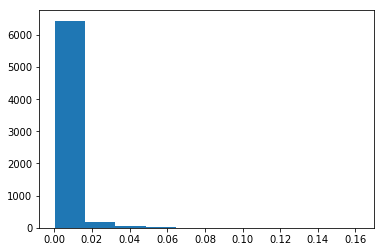

In [0]:
# Plot the degree distribution of the GitHub collaboration network
plt.hist(list(nx.degree_centrality(G).values()))
plt.show()

In [0]:
# Compute the degree centralities of G
deg_cent = nx.degree_centrality(G)

# Compute the maximum degree centrality
max_dc = max(deg_cent.values())

prolific_collaborators = [n for n, dc in deg_cent.items() if dc == max_dc]

# Print the most prolific collaborator(s)
print(prolific_collaborators)

['estado']


### Clique

A clique is a subset of nodes that are fully connected. This concept can be largelly used in study of social network, since in that context they can represent a group of people who all know each other.

When analysing the speeches, we can use the maximal clique to find the biggest group of words that appear in the same context.

In [0]:
cliques = nx.find_cliques(G)

In [0]:
len(list(cliques))

131788

In [0]:
largest_clique = sorted(nx.find_cliques(G), key=lambda x:len(x))[-1]

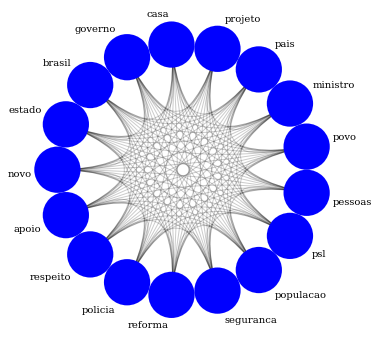

In [0]:
G_lc = G.subgraph(largest_clique)

for n in G_lc.nodes():
    G_lc.node[n]['degree centrality'] = deg_cent[n]

# Create the CircosPlot object
c = CircosPlot(G_lc, node_labels=True, node_grouping='degree centrality',
              node_order='degree centrality')

# Draw the CircosPlot to the screen
c.draw()
plt.show()

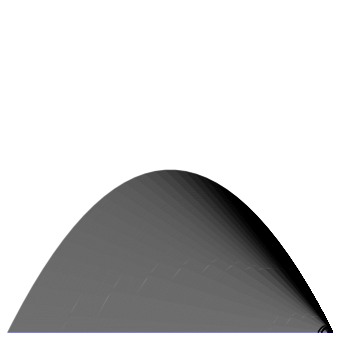

In [0]:
from nxviz import ArcPlot

G_lmc = G_lc.copy()
# Go out 1 degree of separation
for node in list(G_lmc.nodes()):
  if(deg_cent[node] == max_dc):
    G_lmc.add_nodes_from(G.neighbors(node))
    G_lmc.add_edges_from(zip([node]*len(list(G.neighbors(node))), G.neighbors(node)))

# Record each node's degree centrality score
for n in G_lmc.nodes():
    G_lmc.node[n]['degree centrality'] = deg_cent[n]

# Create the ArcPlot object: a
a = ArcPlot(G_lmc, node_order='degree centrality', node_labels=True)

# Draw the ArcPlot to the screen
a.draw()
plt.show()

## PT

In [0]:
pt = dataset.query('party == "PT"')

In [0]:
vec_pt = CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC,decode_error='replace' ,
                                   stop_words=STOP_WORDS, ngram_range=(2,5),
                                   encoding='latin1', strip_accents='unicode')
X = vec_pt.fit_transform(pt.speech)

In [0]:
G = generate_graph(vec_pt.vocabulary_)

n_size = len(G.nodes())
e_size = len(G.edges())
print("There are %i nodes and %i edges" % (n_size, e_size))
nx.write_graphml_lxml(G, "pt.graphml")

There are 8821 nodes and 135347 edges


In [0]:
# Compute the degree centralities of G
deg_cent = nx.degree_centrality(G)

# Compute the maximum degree centrality
max_dc = max(deg_cent.values())

prolific_collaborators = [n for n, dc in deg_cent.items() if dc == max_dc]

# Print the most prolific collaborator(s)
print(prolific_collaborators)

['governo']


### Clique

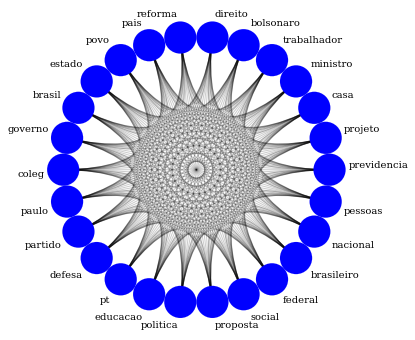

In [0]:
largest_clique = sorted(nx.find_cliques(G), key=lambda x:len(x))[-1]
G_lc = G.subgraph(largest_clique)

for n in G_lc.nodes():
    G_lc.node[n]['degree centrality'] = deg_cent[n]

# Create the CircosPlot object
c = CircosPlot(G_lc, node_labels=True, node_grouping='degree centrality',
              node_order='degree centrality')

# Draw the CircosPlot to the screen
c.draw()
plt.show()

## NOVO

In [0]:
novo = dataset.query('party == "NOVO"')

In [0]:
vec_novo = CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC,decode_error='replace' ,
                                   stop_words=STOP_WORDS, ngram_range=(2,5),
                                   encoding='latin1', strip_accents='unicode')
X = vec_novo.fit_transform(novo.speech)

In [0]:
G = generate_graph(vec_novo.vocabulary_)

n_size = len(G.nodes())
e_size = len(G.edges())
print("There are %i nodes and %i edges" % (n_size, e_size))
nx.write_graphml_lxml(G, "novo.graphml")

There are 1937 nodes and 13443 edges


### Centrality

In [0]:
# Compute the degree centralities of G
deg_cent = nx.degree_centrality(G)

# Compute the maximum degree centrality
max_dc = max(deg_cent.values())

prolific_collaborators = [n for n, dc in deg_cent.items() if dc == max_dc]

# Print the most prolific collaborator(s)
print(prolific_collaborators)

['partido']


In [0]:
deg_cent.values()

dict_values([0.1337809917355372, 0.007231404958677686, 0.005165289256198347, 0.01859504132231405, 0.0015495867768595042, 0.0030991735537190084, 0.01652892561983471, 0.029442148760330578, 0.0025826446280991736, 0.0025826446280991736, 0.006198347107438017, 0.024276859504132234, 0.09659090909090909, 0.018078512396694217, 0.002066115702479339, 0.13636363636363635, 0.016012396694214878, 0.026859504132231406, 0.0030991735537190084, 0.030991735537190084, 0.05526859504132232, 0.02840909090909091, 0.0025826446280991736, 0.002066115702479339, 0.0030991735537190084, 0.0046487603305785125, 0.006714876033057851, 0.0015495867768595042, 0.005681818181818182, 0.0996900826446281, 0.002066115702479339, 0.005681818181818182, 0.002066115702479339, 0.0025826446280991736, 0.07334710743801653, 0.00878099173553719, 0.006198347107438017, 0.0030991735537190084, 0.0025826446280991736, 0.0030991735537190084, 0.0609504132231405, 0.05681818181818182, 0.00878099173553719, 0.021177685950413222, 0.031508264462809916, 

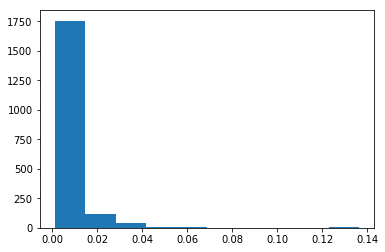

In [0]:
# Plot the degree distribution of the GitHub collaboration network
plt.hist(list(nx.degree_centrality(G).values()))
plt.show()

In [0]:
# Plot the degree distribution of the GitHub collaboration network
# plt.hist(list(nx.betweenness_centrality(G).values()))
# plt.show()

In [0]:
# Compute the degree centralities of G
bet_cent = nx.betweenness_centrality(G)

# Compute the maximum degree centrality
max_bc = max(bet_cent.values())

prolific_collaborators = [n for n, bc in bet_cent.items() if bc == max_bc]

# Print the most prolific collaborator(s)
print(prolific_collaborators)

['novo']


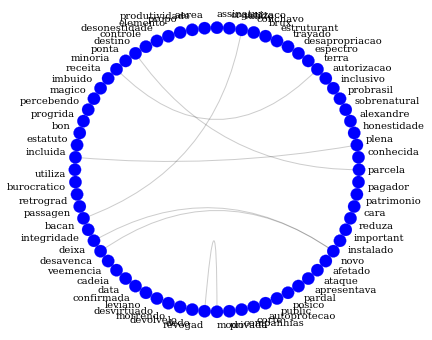

In [0]:
sorted_bc = sorted(bet_cent.values())

top_ten_bc = sorted_bc[:10]

top_nodes = [n for n, bc in bet_cent.items() if (bc==max_bc) or (bc == top_ten_bc[1])]
  
G_bc = G.subgraph(top_nodes)


# Create the CircosPlot object
c = CircosPlot(G_bc, node_labels=True)

# Draw the CircosPlot to the screen
c.draw()
plt.show()

### Clique

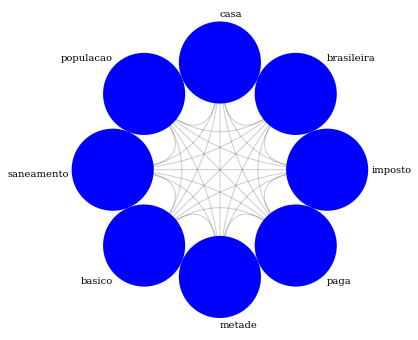

In [0]:
largest_clique = sorted(nx.find_cliques(G), key=lambda x:len(x))[-1]
G_lc = G.subgraph(largest_clique)

for n in G_lc.nodes():
    G_lc.node[n]['degree centrality'] = deg_cent[n]

# Create the CircosPlot object
c = CircosPlot(G_lc, node_labels=True, node_grouping='degree centrality',
              node_order='degree centrality')

# Draw the CircosPlot to the screen
c.draw()
plt.show()

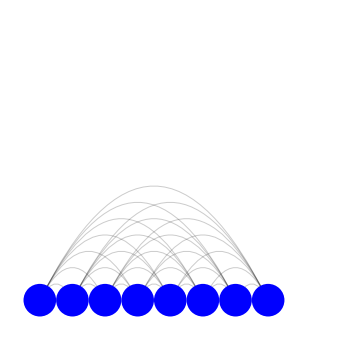

In [0]:
from nxviz import ArcPlot
i = 0
G_lmc = G_lc.copy()
# Go out 1 degree of separation
for node in list(G_lmc.nodes()):
  if((deg_cent[node] > 0.09) and (i < 10)):
    i+=1
    G_lmc.add_nodes_from(G.neighbors(node))
    G_lmc.add_edges_from(zip([node]*len(list(G.neighbors(node))), G.neighbors(node)))

# Record each node's degree centrality score
for n in G_lmc.nodes():
    G_lmc.node[n]['degree centrality'] = deg_cent[n]

# Create the ArcPlot object: a
a = ArcPlot(G_lmc, node_order='degree centrality', node_labels=True)

# Draw the ArcPlot to the screen
a.draw()
plt.show()

## PDT

In [0]:
pdt = dataset.query('party == "PDT"')

In [0]:
vec_pdt = CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC,decode_error='replace' ,
                                   stop_words=STOP_WORDS, ngram_range=(2,5),
                                   encoding='latin1', strip_accents='unicode')
X = vec_pdt.fit_transform(pdt.speech)

In [0]:
G = generate_graph(vec_pdt.vocabulary_)

n_size = len(G.nodes())
e_size = len(G.edges())
print("There are %i nodes and %i edges" % (n_size, e_size))
nx.write_graphml_lxml(G, "pdt.graphml")

There are 4049 nodes and 34459 edges


### Centrality

In [0]:
# Compute the degree centralities of G
deg_cent = nx.degree_centrality(G)

# Compute the maximum degree centrality
max_dc = max(deg_cent.values())

prolific_collaborators = [n for n, dc in deg_cent.items() if dc == max_dc]

# Print the most prolific collaborator(s)
print(prolific_collaborators)

['governo']


### Clique

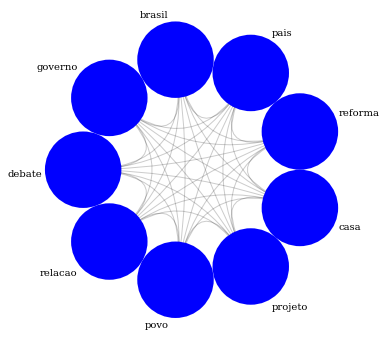

In [0]:
largest_clique = sorted(nx.find_cliques(G), key=lambda x:len(x))[-1]
G_lc = G.subgraph(largest_clique)

for n in G_lc.nodes():
    G_lc.node[n]['degree centrality'] = deg_cent[n]

# Create the CircosPlot object
c = CircosPlot(G_lc, node_labels=True, node_grouping='degree centrality',
              node_order='degree centrality')

# Draw the CircosPlot to the screen
c.draw()
plt.show()